Objective: To predict the sale prices of houses using regression models for given features

Outline:
1. Upload the given training and test data set
2. Concatenate the train and test features to work on missing values
3. Fill out all the missing values using data description, or mean values or most frequent occuring value accordingly
4. Removing skewness from the data by log(feature+1) transformation
5. Drop outliers from the training data
6. Seperate data to train and test sets 
6. Implement lasso regression model using cross validation to determine best parameter (which gives minimum root mean squared error for the cross validation set)
7. Similarily implement extreme gradient boosting (XGBoost) regression model
8. Combine the prediction of both models and save the output to the csv file.

Conclusion: most important feature in the data set is the above ground living square area. for lasso and XGBoost regression the cross validation rmse is 0.107 and test score is 0.119

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib
import xgboost as xgb

In [84]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoCV
from scipy.stats import skew
from sklearn.cross_validation import cross_val_score

# Uploading data to the code

In [85]:
train_data = pd.read_csv('train_h.csv')
test_data = pd.read_csv('test_h.csv')
num_features = test_data.shape[1]
train_data.head()  #Looking at the first five rows of train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Preprocessing 

## A. Handling Missing Values


In [86]:
# Function for printing columns wthic
def MissingValues(dataX):
    missing=dataX.isnull().sum()
    print("Missing %d Columns Are: \n%s" %((missing[missing>0].shape[0]),str(missing[missing>0])))

In [87]:
# Combining test_data and train_data for data preprocessing step
data = pd.concat([train_data.drop(['Id','SalePrice'],axis=1),test_data.drop('Id',axis=1)])

# checking to see the columns which have missing values in them
MissingValues(data)

Missing 34 Columns Are: 
MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


In [88]:
''' Alleys Missing 2721 out of 2919
Null Alley Values corresponds to not having any alley access 
Can replace null values by a string NAA (No Alley Access) '''

data['Alley'] = data['Alley'].fillna('NAA')

'''Second column with missing values is BsmtCond with 82 missing values in it
and from the description Null values means No Basebemt
Replace Null Values with NB'''

data['BsmtCond']=data['BsmtCond'].fillna('NB')

''' 82 Basement Exposures missing and according to description null value means No Basement, 
So will fill them with NB'''

data['BsmtExposure']=data['BsmtExposure'].fillna('NB')

'''BsmtFinSF1 and BsmtFinSF2 (Type 1 and 2 Finished Square Feet) Has one missing Values each
 Fill it with median value'''

data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].median())
data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].median())

'''Missing Values in BsmtFinType1 and BsmtFinType2 (Ratings of Basement Finished Area) means
No Basement, so filling missing values with NB'''

data['BsmtFinType1'] = data['BsmtFinType1'].fillna('NB')
data['BsmtFinType2'] = data['BsmtFinType2'].fillna('NB')

'''Have 2 missing values in BsmtFullBath, To fill these values, first check if these houses have basements or not'''


'''Filling missing values with zeros for BsmtFullBath and BsmtHalfBath (Becuase there are no basements in these houses)'''

data['BsmtFullBath']=data['BsmtFullBath'].fillna(0.0)
data['BsmtHalfBath']=data['BsmtHalfBath'].fillna(0.0)

'''NO Basements where BsmtQual has missing values
Filling missing values with NB'''

data['BsmtQual']=data['BsmtQual'].fillna('NB')

'''Since no basement when BsmtUnfSF is missing data, filling missing values with 0'''
data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(0.0)

'''Filling missing value in Electrical Column with most frequent value'''

data['Electrical']=data['Electrical'].fillna(data['Electrical'].value_counts().idxmax())

data['Exterior1st']=data['Exterior1st'].fillna(data['Exterior1st'].value_counts().idxmax())

data['Exterior2nd']=data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().idxmax())

data['Fence']=data['Fence'].fillna('NF')

data['FireplaceQu']=data['FireplaceQu'].fillna('NFire')

data['Functional']=data['Functional'].fillna(data['Functional'].value_counts().idxmax())

# Filling with median in GarageArea
data['GarageArea']=data['GarageArea'].fillna(data['GarageArea'].median())

data['GarageCars']=data['GarageCars'].fillna(data['GarageCars'].value_counts().idxmax())

'''Null values in GarageCond, GarageFinish, GarageQual, GarageType means no garage
So filling missing values with NG'''

data['GarageCond'] = data['GarageCond'].fillna('NG')
data['GarageFinish'] = data['GarageFinish'].fillna('NG')
data['GarageQual'] = data['GarageQual'].fillna('NG')
data['GarageType'] = data['GarageType'].fillna('NG')
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0.0)

data['KitchenQual']=data['KitchenQual'].fillna(data['KitchenQual'].value_counts().idxmax())

data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].median())

data['MSZoning']=data['MSZoning'].fillna(data['MSZoning'].value_counts().idxmax())

data['MasVnrArea'] = data['MasVnrArea'].fillna(data['MasVnrArea'].median())

data['MasVnrType'] = data['MasVnrType'].fillna(data['MasVnrType'].value_counts().idxmax())

# Replacing missing values in MiscFeature with None

data['MiscFeature']=data['MiscFeature'].fillna('None')

# Replacing missing values in PoolQC with NP (meaning no pool)

data['PoolQC'] = data['PoolQC'].fillna('NP')

data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().idxmax())

data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(0.0)

data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().idxmax())

# Checking if any missing values remained
MissingValues(data)

Missing 0 Columns Are: 
Series([], dtype: int64)


In [89]:
'''Now that there are no missing values in data,
Next step is to remove skeweness from the data and convert all string into dummy variables
To be given as input to the regression model'''

'Now that there are no missing values in data,\nNext step is to remove skeweness from the data and convert all string into dummy variables\nTo be given as input to the regression model'

## B. Handling Skewed Data 
####  log(feature+1) transformation of skewed data

In [90]:
for i in range(num_features-1):
    if data.iloc[:,i].dtype!='O':
        skewed = skew(data.iloc[:,i])
        if skewed>0.75:
            data.iloc[:,i]=np.log1p(data.iloc[:,i])

(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

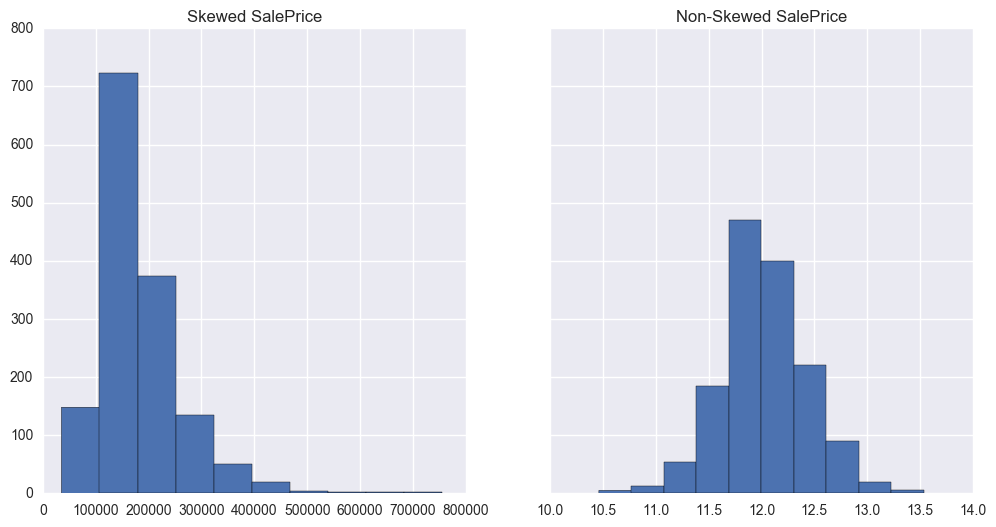

In [92]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
matplotlib.rcParams['figure.figsize']= 12.0,6.0

ax1.set_title('Skewed SalePrice')
ax1.hist(train_data['SalePrice'])

# Removing skewness from the training output data (SalePrice data)
y_train = np.log1p(train_data['SalePrice'].astype('float'))

ax2.set_title('Non-Skewed SalePrice')
ax2.hist(y_train)

# Convert categorical variable into dummy variables

In [93]:
data = pd.get_dummies(data)

In [94]:
# now that we have preprocessed the data, let's divide the combined data to test and training data sets.
X_train = data.iloc[0:train_data.shape[0]]
X_test = data.iloc[train_data.shape[0]:]

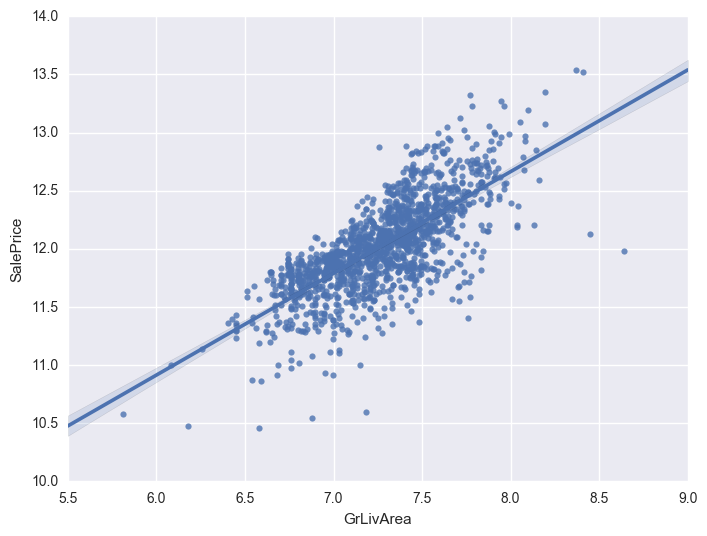

In [95]:
# plotting Saleprice with respect to the house total living area
matplotlib.rcParams['figure.figsize']=8,6
sns.regplot(x="GrLivArea",y='SalePrice',data=pd.concat([X_train["GrLivArea"],y_train],axis=1))

We see that their are few outliers (which will affect the model acuracy and may result in overfit, it is best to remove these outliers from the training data set. So, the next step is to exactly that.

In [96]:
# Removing outliers from the training set
outlier = [523,1298,30,495,968,691,916,1182]
y_train=y_train.drop(outlier)
X_train= X_train.drop(outlier)

# Regression models to predict housing prices.

Since, the data sets has a lot of features and from looking at the description of these features it becomes apparent that all of these features might not be the deciding factors of housing prices. So Lasso regression is the first regression model that comes to mind.
For this project I implemented the lasso regression as well as the extreme gradient boosting (which is a powerful regression model), and averaged the result of these two model to get the best prediction of house prices.

In [97]:
# Function to calculate root mean squared error of a model
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## A. Lasso Regression Model

the least cross validation rmse is: 0.107758
Best alpha chosen by Lasso model 0.0005
Total Features: 302
Features Chosen by Lasso Model: 106


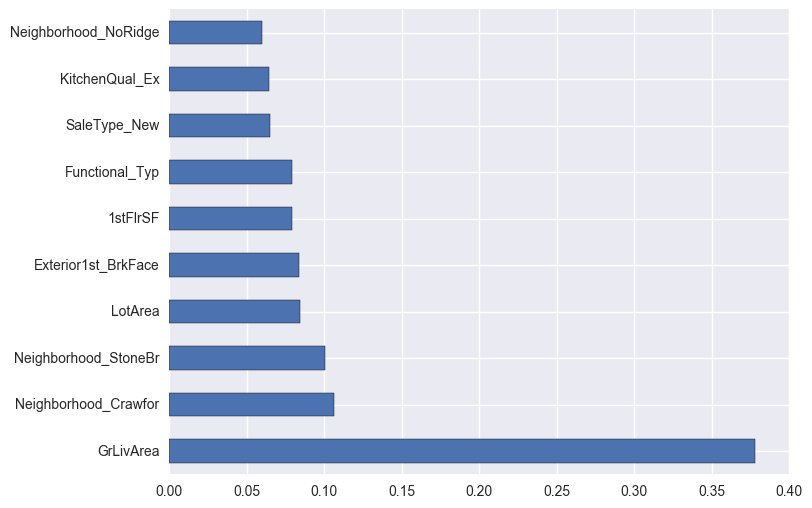

In [98]:
model_lasso = LassoCV(alphas=[1e-4, 5e-4, 1e-3, 5e-3]).fit(X_train,y_train)
print('the least cross validation rmse is: %f' %rmse_cv(model_lasso).mean())

print('Best alpha chosen by Lasso model '+ str(model_lasso.alpha_))

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print('Total Features: '+str(X_test.shape[1]) + '\n' + 'Features Chosen by Lasso Model: '+str(sum(coef!=0)))


# plotting the most important features
imp_features = coef.sort_values(ascending=False).head(10)
imp_features.plot(kind = "barh")

'''making prediction on the test data set:
Since I transformed the training price data using log(price+1), it is neccessary to transform the predicted price back
to the original form'''

lasso_preds = np.expm1(model_lasso.predict(X_test))


## B. xgboost model

least_rmse: 0.115447666667best_max_depth: 3best_eta: 0.1
root mean squared error of the final xgb model: 0.115337


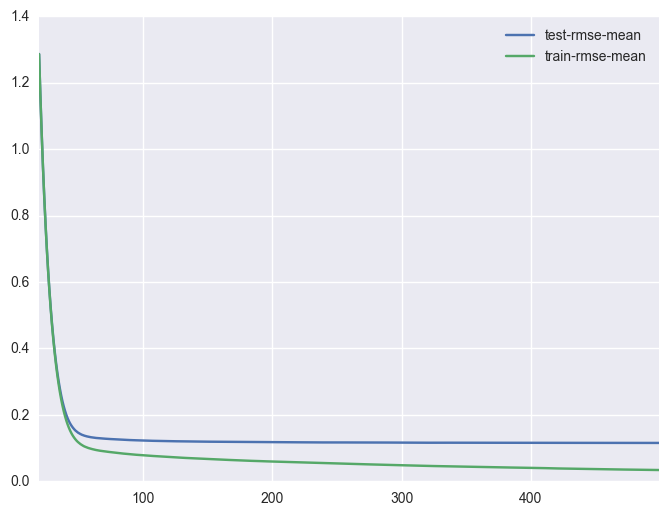

In [99]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

# Running a loop for various parameters and deciding the best ones using cross-validation

max_depths = [1,2,3,4,5,6]
eta=[0.1,0.3,0.5,0.7,0.9]
least_rmse = 1
best_max_depth = 0
best_eta = 0
for d in max_depths:
    for e in eta:
        params = {"max_depth":d, "eta":e}
        model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
        rmse = model['test-rmse-mean'].iloc[-1]
        if rmse<least_rmse:
            least_rmse = rmse
            best_max_depth = d
            best_eta = e
            
print('least_rmse: ' + str(least_rmse) + 'best_max_depth: ' + str(best_max_depth) + 'best_eta: ' + str(best_eta))

# building a xgb model using tuned parameters 
params = {"max_depth":best_max_depth, "eta":best_eta}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

# plotting the test and train mean rmse
model.loc[20:,["test-rmse-mean", "train-rmse-mean"]].plot()


# building extreme gradient boosting regression model and fitting the training data to it.
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=best_max_depth, learning_rate=best_eta) 
model_xgb.fit(X_train, y_train)

print('root mean squared error of the final xgb model: %f' %rmse_cv(model_xgb).mean())

# Predicting housing prices on the test data set using above model
xgb_preds = np.expm1(model_xgb.predict(X_test))

# Final Predictions

In [100]:
solution = pd.DataFrame(test_data['Id'], columns=['Id'])
solution["SalePrice"]= 0.7*lasso_preds+0.3*xgb_preds
solution.to_csv("Housing23.csv", index = False)